In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc


In [14]:
os.makedirs('csv_files',exist_ok=True)
os.makedirs('outputs',exist_ok = True)

# **Load Data**

In [15]:
trades = pd.read_csv('historical_data.csv')
sentiment = pd.read_csv('fear_greed_index.csv')

print("Trades shape:",trades.shape)
print("Sentiment shape:", sentiment.shape)
trades.head()

Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


# **Cleaning and datetime handling**

In [16]:
#normalize column names to format
trades.columns = [c.strip().lower().replace(" ","_") for c in trades.columns]
sentiment.columns = [c.strip().lower().replace(" ","_") for c in sentiment.columns]

if 'timestamp' in trades.columns:
  trades['timestamp_ms'] = pd.to_datetime(trades['timestamp'],unit='ms',utc =True,errors = 'coerce')

  if trades['timestamp_ms'].isna().mean() > 0.5:
    trades['timestamp_ms'] = pd.to_datetime(trades['timestamp'],unit = 's',errors = 'coerce',utc = True)

else:
  trades['timestamp_ms'] = pd.NaT

if 'timestamp_ist' in trades.columns:
  trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'],format = "%d-%m-%Y %H:%M",errors = 'coerce')
elif 'timestamp_ist' in trades.columns or 'timestamp_ist' in trades.columns:
  trades['timestamp_ist'] = pd.to_datetime(trades.get('timestamp_ist', trades.get('timestamp_ ist')), errors='coerce')
else:
  possible = [c for c in trades.columns if 'ist' in c or ('timestamp' in c and trades[c].dtype == object and trades[c].str.contains(r'\d{2}-\d{2}-\{4}',na = False).any())]
  if possible:
    trades['timestamp_ist'] = pd.to_datetime(trades.get('timestamp_ist',trades.get('timestamp_ist')),errors='coerce')
  else:
    trades['timestamp_ist'] = pd.NaT


if 'date' in sentiment.columns:
  sentiment['date'] = pd.to_datetime(sentiment['date'],format="%Y-%m-%d",errors='coerce')
else:
  if 'timestamp' in sentiment.columns:
    sentiment['date'] = pd.to_datetime(sentiment['timestamp'],unit='s',errors = 'coerce').dt.normalize()
  else:
    raise ValueError("No date column found")

if 'classification' in sentiment.columns:
  sentiment['classification'] = sentiment['classification'].str.lower().str.strip()

print("Sample timestamps:")
print(trades[['timestamp_ms','timestamp_ist']].head(3))
print("Sentiment classification counts:")
print(sentiment['classification'].value_counts(dropna=False))

Sample timestamps:
               timestamp_ms       timestamp_ist
0 2024-10-27 03:33:20+00:00 2024-12-02 22:50:00
1 2024-10-27 03:33:20+00:00 2024-12-02 22:50:00
2 2024-10-27 03:33:20+00:00 2024-12-02 22:50:00
Sentiment classification counts:
classification
fear             781
greed            633
extreme fear     508
neutral          396
extreme greed    326
Name: count, dtype: int64


# **Merging sentiment into trades**

In [17]:
if trades['timestamp_ms'].notna().any():
  trade_date = (trades['timestamp_ms'].dropna().dt.tz_convert('Asia/Kolkata').dt.normalize().dt.tz_localize(None))
  trades['trade_date'] = trade_date.reindex(trades.index)
else:
  trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'],errors='coerce')
  trades['trade_date'] = trades['timestamp_ist'].dt.normalize()

sentiment['date'] = pd.to_datetime(sentiment['date'],errors='coerce').dt.tz_localize(None)

merged = trades.merge(sentiment[['date','value','classification']],left_on='trade_date',right_on='date',how='left')

cols = list(merged.columns)
if cols.count('timestamp_ist') > 1:
  merged = merged.loc[:,~merged.columns[::-1].duplicated()][::-1]

merged['classification'] = merged['classification'].fillna(method='ffill').fillna(method='bfill')
print("merged shape",merged.shape)
print(merged[['trade_date','date','classification']].head())

merged shape (211224, 21)
  trade_date       date classification
0 2024-10-27 2024-10-27          greed
1 2024-10-27 2024-10-27          greed
2 2024-10-27 2024-10-27          greed
3 2024-10-27 2024-10-27          greed
4 2024-10-27 2024-10-27          greed


C:\Users\namir\AppData\Local\Temp\ipykernel_4512\3166609399.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['classification'] = merged['classification'].fillna(method='ffill').fillna(method='bfill')


# **Feature engineering**

In [18]:
for col in ['execution_price','size_usd','size_tokens','closed_pnl','fee','value']:
  if col in merged.columns:
    merged[col] = pd.to_numeric(merged[col],errors='coerce')
  else:
    merged[col] = np.nan

merged['is_profit'] = (merged['closed_pnl'] > 0).astype(int)
merged['is_long'] = merged['side'].str.lower().map({'buy':1,'sell':0})

sent_series = sentiment.set_index('date')['value'].sort_index()
sent7 = sent_series.rolling(7,min_periods=1).mean()
sent30 = sent_series.rolling(30,min_periods=1).mean()
sent_df = pd.DataFrame({'date':sent_series.index,'sent7':sent7,'sent30':sent30}).reset_index(drop=True)

if 'sent7' not in merged.columns or 'sent30' not in merged.columns:
  merged = merged.merge(sent_df,left_on='trade_date',right_on='date',how='left')

if merged.columns.tolist().count('timestamp_ist')>11:
  merged = merged.loc[:,~merged.columns[::-1].duplicated()][::-1]

merged['timestamp_ist'] = pd.to_datetime(merged.get('timestamp_ist'),errors='coerce')
merged['timestamp_ms'] = pd.to_datetime(merged.get('timestamp_ms'),errors='coerce',utc=True)

print("columns now include sent7/sent30" , 'sent7' in merged.columns,'sent30' in merged.columns)
merged[['trade_date','sent7','sent30']].head(3)


columns now include sent7/sent30 True True


,trade_date,sent7,sent30
0,2024-10-27,71.571429,57.966667
1,2024-10-27,71.571429,57.966667
2,2024-10-27,71.571429,57.966667


# **Trader level aggregation**

In [19]:
agg = merged.groupby('account').agg(
    total_trades=('is_profit','count'),
    profit_trades=('is_profit','sum'),
    avg_pnl=('closed_pnl','mean'),
    med_pnl=('closed_pnl','median'),
    avg_size_usd=('size_usd','mean'),
    avg_fee=('fee','mean'),
    win_rate=('is_profit','mean'),
    pnl_std=('closed_pnl','std')
).reset_index().fillna(0)

# risk-adjusted metric
agg['sharpe_like'] = agg['avg_pnl'] / (agg['pnl_std'] + 1e-9)

agg.to_csv("csv_files/trader_summary.csv", index=False)
agg.head(5)


,account,total_trades,profit_trades,avg_pnl,med_pnl,avg_size_usd,avg_fee,win_rate,pnl_std,sharpe_like
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,1373,419.127768,0.000,16159.576734,1.939579,0.359612,4692.452329,0.089320
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,3223,6.577654,0.000,1653.226327,0.374978,0.442720,134.073473,0.049060
2,0x271b280974205ca63b716753467d5a371de622ab,3809,1150,-18.492043,0.000,8893.000898,2.436593,0.301917,542.182659,-0.034107
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,5838,9.951530,0.000,507.626933,0.166657,0.438585,113.269353,0.087857
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,1684,52.071011,0.429,3138.894782,0.959616,0.519914,255.829091,0.203538


# **Exploratory Analysis**

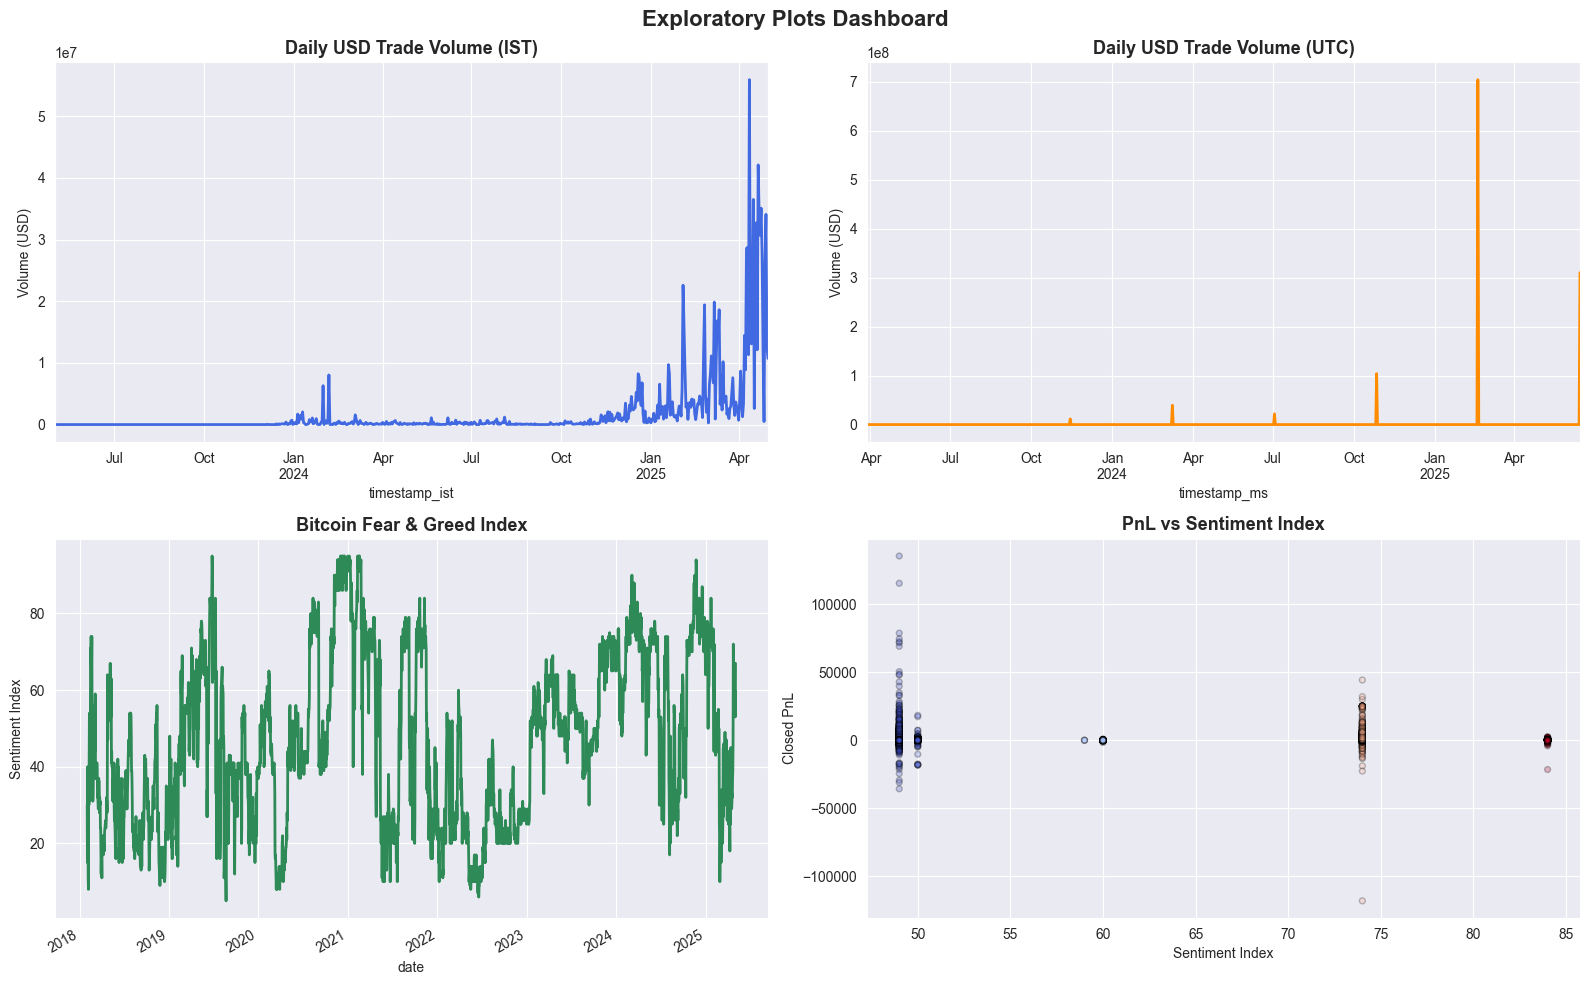

In [20]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("Set2")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

#Daily USD Trade Volume (IST)
if merged['timestamp_ist'].notna().any():
    axes[0,0].set_title("Daily USD Trade Volume (IST)", fontsize=13, fontweight="bold")
    merged.set_index('timestamp_ist')['size_usd'].resample('D').sum().plot(ax=axes[0,0], color='royalblue', linewidth=2)
    axes[0,0].set_ylabel("Volume (USD)")
else:
    axes[0,0].text(0.5,0.5,"No timestamp_ist available", ha='center')

# daily USD Trade Volume (UTC)
if merged['timestamp_ms'].notna().any():
    axes[0,1].set_title("Daily USD Trade Volume (UTC)", fontsize=13, fontweight="bold")
    merged.set_index('timestamp_ms')['size_usd'].resample('D').sum().plot(ax=axes[0,1], color='darkorange', linewidth=2)
    axes[0,1].set_ylabel("Volume (USD)")
else:
    axes[0,1].text(0.5,0.5,"No timestamp_ms available", ha='center')

#Sentiment over time
axes[1,0].set_title("Bitcoin Fear & Greed Index", fontsize=13, fontweight="bold")
if 'value' in sentiment.columns:
    sentiment.set_index('date')['value'].plot(ax=axes[1,0], color='seagreen', linewidth=2)
    axes[1,0].set_ylabel("Sentiment Index")
else:
    axes[1,0].text(0.5,0.5,"No sentiment value column", ha='center')

#PnL vs Sentiment scatter (colored)
axes[1,1].set_title("PnL vs Sentiment Index", fontsize=13, fontweight="bold")
cmap = plt.get_cmap("coolwarm")
axes[1,1].scatter(merged['value'], merged['closed_pnl'], alpha=0.25,
                  c=merged['value'], cmap=cmap, edgecolor='k', s=18)
axes[1,1].set_xlabel("Sentiment Index")
axes[1,1].set_ylabel("Closed PnL")

plt.suptitle("Exploratory Plots Dashboard", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig("outputs/exploratory_plots_dashboard.png", dpi=150, bbox_inches='tight')
plt.show()


C:\Users\namir\AppData\Local\Temp\ipykernel_4512\449389216.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_summary = merged.groupby('sentiment_state').agg(


📊 Fear vs Greed Summary:
  sentiment_state    avg_pnl  win_rate   avg_volume  trade_count
0            Fear  50.047622  0.415146  5259.977837       133871
1           Greed  46.501542  0.404548  6296.186954        77353


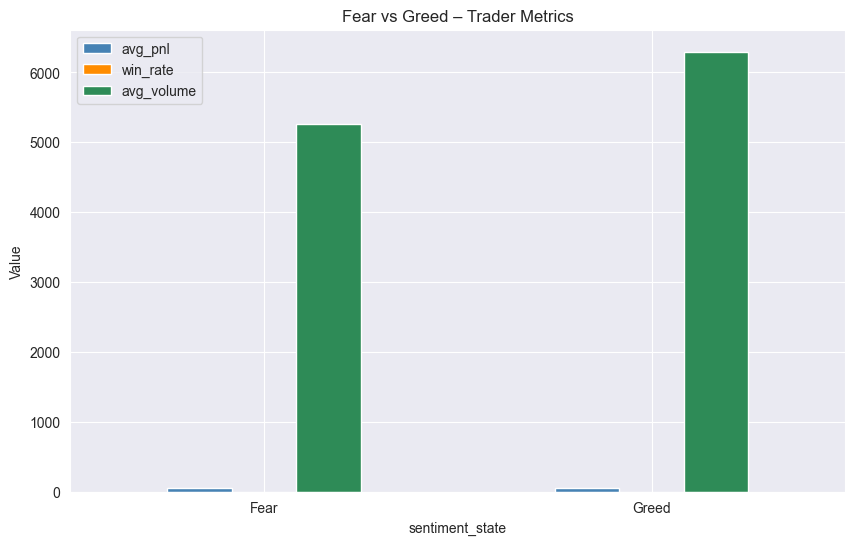

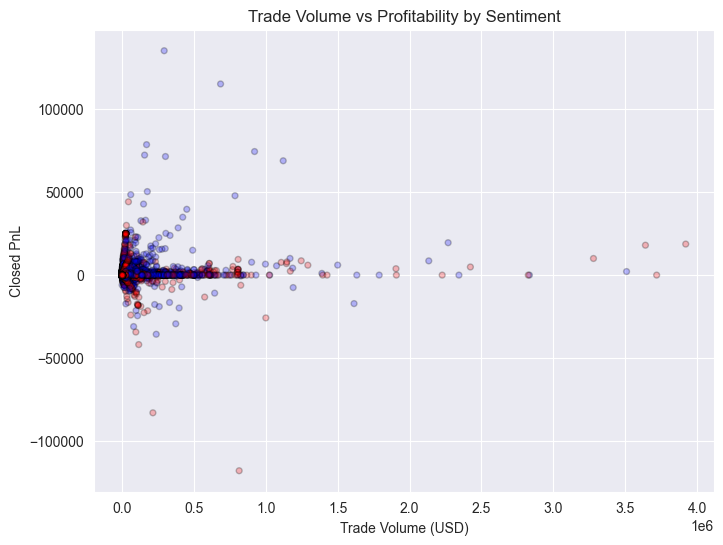

Sharpe ratios by sentiment:
  sentiment_state   mean_pnl     std_pnl  sharpe_ratio
0            Fear  50.047622  909.121796      0.055051
1           Greed  46.501542  936.292966      0.049666


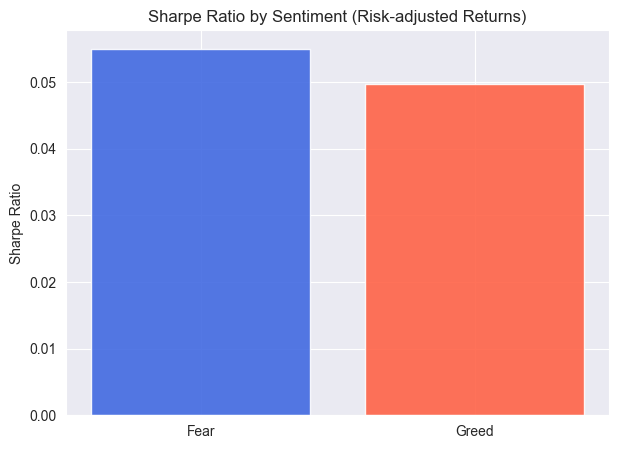

In [9]:
merged['sentiment_state'] = pd.cut(merged['value'].fillna(50), bins=[-1,49.9999,100], labels=['Fear','Greed'])

# Comparison table
sentiment_summary = merged.groupby('sentiment_state').agg(
    avg_pnl = ('closed_pnl','mean'),
    win_rate = ('is_profit','mean'),
    avg_volume = ('size_usd','mean'),
    trade_count = ('account','count')
).reset_index()

print("📊 Fear vs Greed Summary:")
print(sentiment_summary)
sentiment_summary.to_csv("csv_files/fear_greed_comparison.csv", index=False)

#barchart comparision
sentiment_summary.set_index('sentiment_state')[['avg_pnl','win_rate','avg_volume']].plot(
    kind='bar', figsize=(10,6), color=['steelblue','darkorange','seagreen'])
plt.title("Fear vs Greed – Trader Metrics")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.savefig("outputs/fear_greed_comparison.png", dpi=150)
plt.show()

# Volume vs Profitability scatter colored by sentiment_state (handle NA)
merged['sentiment_state'] = merged['sentiment_state'].astype(str).fillna('Unknown')
color_map = {'Fear':'blue','Greed':'red','Unknown':'gray'}
plt.figure(figsize=(8,6))
plt.scatter(merged['size_usd'], merged['closed_pnl'],
            alpha=0.25, c=merged['sentiment_state'].map(color_map), edgecolor='k', s=18)
plt.title("Trade Volume vs Profitability by Sentiment")
plt.xlabel("Trade Volume (USD)")
plt.ylabel("Closed PnL")
plt.savefig("outputs/volume_vs_pnl.png", dpi=150)
plt.show()

# Sharpe ratio by sentiment (mean/std)
sharpe_summary = merged.groupby('sentiment_state').agg(mean_pnl=('closed_pnl','mean'), std_pnl=('closed_pnl','std')).reset_index()
sharpe_summary['sharpe_ratio'] = sharpe_summary['mean_pnl'] / (sharpe_summary['std_pnl'] + 1e-9)
print("Sharpe ratios by sentiment:")
print(sharpe_summary)
sharpe_summary.to_csv("csv_files/sharpe_by_sentiment.csv", index=False)

plt.figure(figsize=(7,5))
plt.bar(sharpe_summary['sentiment_state'], sharpe_summary['sharpe_ratio'], color=['royalblue','tomato'], alpha=0.9)
plt.title("Sharpe Ratio by Sentiment (Risk-adjusted Returns)")
plt.ylabel("Sharpe Ratio")
plt.savefig("outputs/sharpe_by_sentiment.png", dpi=150)
plt.show()


# **Clustering Traders**

Selected k = 2 (silhouette=0.513)


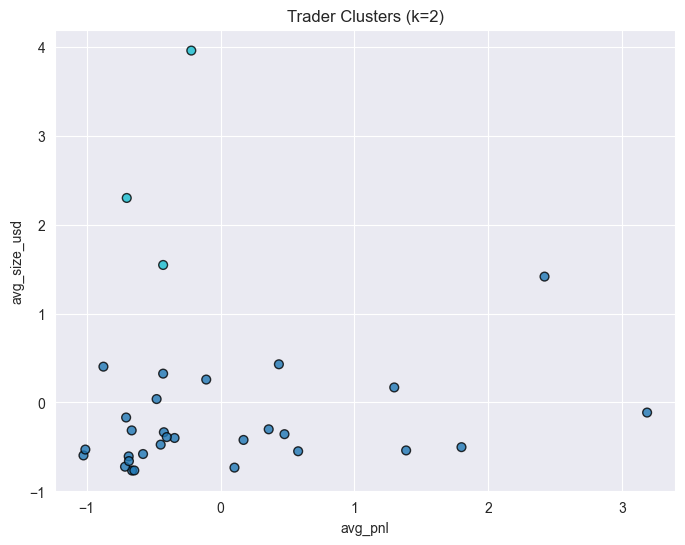

   cluster  avg_pnl  avg_size_usd  avg_fee  win_rate  pnl_std  sharpe_like
0        0  103.858      4077.739    0.756     0.403  888.469        0.117
1        1   38.024     24666.436    5.845     0.400  542.726        0.061


In [10]:
features = ['avg_pnl','avg_size_usd','avg_fee','win_rate','pnl_std']
X = agg[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)
#to find best k i use silhouette method
best_k, best_score = 4, -1
for k in range(2,9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    score = silhouette_score(X_scaled, km.labels_)
    if score > best_score:
        best_k, best_score = k, score

print(f"Selected k = {best_k} (silhouette={best_score:.3f})")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
agg['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=agg['cluster'], cmap='tab10', s=40, edgecolor='k', alpha=0.8)
plt.title(f"Trader Clusters (k={best_k})")
plt.xlabel(features[0]); plt.ylabel(features[1])
plt.savefig("outputs/trader_clusters.png", dpi=150)
plt.show()

# Cluster profile table
cluster_profile = agg.groupby('cluster')[features + ['sharpe_like']].mean().round(3).reset_index()
print(cluster_profile)
cluster_profile.to_csv("csv_files/cluster_profile.csv", index=False)


# **RandomForest Model to predict profitable trade**

ROC AUC: 0.960850870658362
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     24871
           1       0.87      0.87      0.87     17374

    accuracy                           0.89     42245
   macro avg       0.89      0.89      0.89     42245
weighted avg       0.89      0.89      0.89     42245



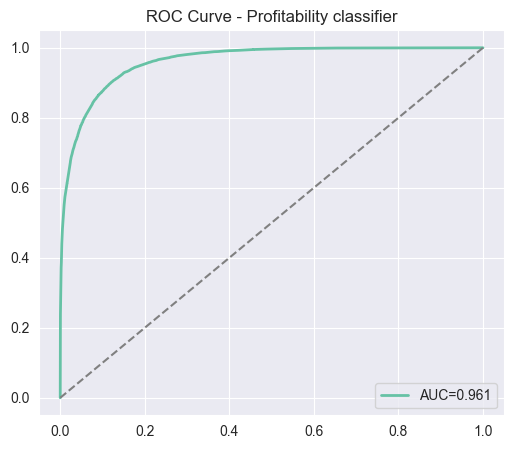

In [11]:
cols = ['execution_price','size_usd','fee','is_long','value','sent7','sent30']

for c in cols:
    if c not in merged.columns:
        merged[c] = np.nan

model_df = merged.dropna(subset=['is_profit'])[cols + ['is_profit']].fillna(0)

X = model_df[cols]
y = model_df['is_profit']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test,y_proba))
print(classification_report(y_test, clf.predict(X_test)))

# ROC curve
fpr,tpr,_ = roc_curve(y_test,y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr,tpr,label=f"AUC={auc(fpr,tpr):.3f}", linewidth=2)
plt.plot([0,1],[0,1],'--', color='gray')
plt.legend(loc='lower right')
plt.title("ROC Curve - Profitability classifier")
plt.savefig("outputs/model_roc.png", dpi=150)
plt.show()


In [ ]:
#shap explainability
cols = ['execution_price','size_usd','fee','is_long','value','sent7','sent30']
explainer = shap.Explainer(clf, X_train, feature_names=cols)
sample = X_test.sample(min(200, len(X_test)), random_state=1)
shap_values = explainer(sample)

# Bar summary
shap.summary_plot(shap_values, sample, plot_type="bar", show=True)
# Beeswarm
shap.summary_plot(shap_values, sample, show=True)
plt.savefig("outputs/shap_summary.png", dpi=150, bbox_inches='tight')

# **Save outputs**

In [12]:
merged.to_csv("csv_files/merged_trades_sentiment.csv", index=False)
agg.to_csv("csv_files/trader_summary.csv", index=False)
print("Saved: csv_files/merged_trades_sentiment.csv and csv_files/trader_summary.csv")
print("Saved plots to outputs/*.png")
#summary
print("\nClassification counts in merged after merge:")
print(merged['classification'].value_counts(dropna=False).head(10))
print("\nSentiment-state counts (numeric split):")
print(merged['sentiment_state'].value_counts(dropna=False))


Saved: csv_files/merged_trades_sentiment.csv and csv_files/trader_summary.csv
Saved plots to outputs/*.png

Classification counts in merged after merge:
classification
neutral          167973
greed             36289
extreme greed      6962
Name: count, dtype: int64

Sentiment-state counts (numeric split):
sentiment_state
Fear     133871
Greed     77353
Name: count, dtype: int64
